In [122]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt

In [123]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45847 entries, 0 to 45846
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     45847 non-null  object 
 1   description               45847 non-null  object 
 2   summary                   45831 non-null  object 
 3   installs                  45847 non-null  object 
 4   minInstalls               45847 non-null  float64
 5   score                     45847 non-null  float64
 6   ratings                   45847 non-null  float64
 7   reviews                   45847 non-null  float64
 8   histogram                 45847 non-null  object 
 9   price                     45847 non-null  float64
 10  free                      45847 non-null  int64  
 11  currency                  45847 non-null  object 
 12  sale                      45847 non-null  bool   
 13  offersIAP                 45847 non-null  bool   
 14  inAppP

In [144]:
df = df[df['year'].notna()]

## Need to do a transformation for year - scaled to zero

In [145]:
X = df[['title','ratings','free','containsAds','genre','editorsChoice','contentRating','year']]

y = df['score']

In [146]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr,test_size=.20, random_state=10)

In [147]:
X_train_cont = X_train[['ratings','free','containsAds','editorsChoice','year']]
X_val_cont = X_val[['ratings','free','containsAds','editorsChoice','year']]

In [148]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_train[['genre','contentRating']])

ohe_x_train = ohe.transform(X_train[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_train_df = pd.DataFrame(ohe_x_train, columns=columns, index=X_train.index)

In [149]:
ohe_v = OneHotEncoder(drop='first', sparse=False)

ohe_v.fit(X_val[['genre','contentRating']])

ohe_x_val = ohe_v.transform(X_val[['genre','contentRating']])

columns_v = ohe_v.get_feature_names(['genre','contentRating'])

ohe_x_val_df = pd.DataFrame(ohe_x_val, columns=columns_v, index=X_val.index)

In [150]:
#Merge cont and cat DFs
combo_train_df = pd.concat([X_train_cont, ohe_x_train_df], axis=1)

combo_val_df =  pd.concat([X_val_cont, ohe_x_val_df], axis=1)

In [151]:
lr = LinearRegression()

lr.fit(combo_train_df, y_train)

y_pred = lr.predict(combo_val_df)
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(combo_val_df, y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.12
MSE of linear regression on val set: 0.44


In [152]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df.columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : -0.18
containsAds : 0.10
editorsChoice : 0.10
year : 0.01
genre_Adventure : -0.02
genre_Arcade : 0.05
genre_Art & Design : 0.07
genre_Auto & Vehicles : 0.17
genre_Beauty : -0.05
genre_Board : 0.17
genre_Books & Reference : 0.37
genre_Business : 0.16
genre_Card : 0.27
genre_Casino : 0.35
genre_Casual : 0.03
genre_Comics : -0.01
genre_Communication : 0.05
genre_Dating : -0.10
genre_Education : 0.27
genre_Educational : 0.10
genre_Entertainment : -0.03
genre_Events : -0.08
genre_Finance : 0.09
genre_Food & Drink : 0.23
genre_Health & Fitness : 0.32
genre_House & Home : 0.07
genre_Libraries & Demo : 0.10
genre_Lifestyle : 0.15
genre_Maps & Navigation : 0.09
genre_Medical : 0.18
genre_Music : -0.03
genre_Music & Audio : 0.18
genre_News & Magazines : -0.01
genre_Parenting : 0.27
genre_Personalization : 0.23
genre_Photography : -0.01
genre_Productivity : 0.11
genre_Puzzle : 0.22
genre_Racing : -0.00
genre_Role Playing : 0.03
genre_Shopping :

In [153]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(combo_val_df)
check['resid'] = check['pred'] - check['score']

In [159]:
check.sort_values('resid',ascending =True)

,title,ratings,free,containsAds,genre,editorsChoice,contentRating,year,score,pred,resid
29065,Dirt Bike Cop Race Free Flip Motocross Racing ...,1839.0,1,1,Racing,0,Teen,2019.0,4.931579,3.944979,-0.986600
3291,Madani Channel,13279.0,1,0,Video Players & Editors,0,Everyone,2013.0,4.745113,3.769177,-0.975936
31184,Empik Foto,38830.0,1,0,Photography,0,Everyone,2017.0,4.852648,3.939519,-0.913129
15051,Buffalo Wild Wings,43823.0,1,0,Entertainment,0,Everyone,2015.0,4.773402,3.900153,-0.873249
12099,Find My Family - GPS Location Tracker,6418.0,1,0,Lifestyle,0,Everyone,2016.0,4.873486,4.000392,-0.873094
...,...,...,...,...,...,...,...,...,...,...,...
39006,Wink - Smart Home,9436.0,1,0,Tools,0,Everyone,2013.0,1.343005,3.873239,2.530234
33084,Owl - Predictor Mania,4370.0,1,1,Entertainment,0,Everyone,2018.0,1.297052,3.942049,2.644997
6119,Ikariam Mobile,57642.0,1,0,Arcade,0,Everyone,2013.0,1.324779,3.998448,2.673669
30254,Home Quarantine - Poland (Kwarantanna domowa),14224.0,1,0,Medical,0,Everyone,2020.0,1.402204,4.108372,2.706168


In [163]:
check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

,title,ratings,free,containsAds,genre,editorsChoice,contentRating,year,score,pred,resid
32286,Spring Wallpaper,5198.0,1,1,Personalization,0,Everyone,2014.0,4.208413,4.159391,-0.049022
31261,Dolphin Bubble Shooter,5209.0,1,1,Puzzle,0,Everyone,2014.0,4.181993,4.146496,-0.035496
14246,Brad's Deals,3293.0,1,1,Shopping,0,Mature 17+,2014.0,4.145896,4.083047,-0.062850
15284,French - English offline dict.,29207.0,1,1,Books & Reference,0,Everyone 10+,2012.0,4.324093,4.367284,0.043191
32070,Human Life,38110.0,1,1,Puzzle,0,Everyone,2015.0,4.343742,4.243924,-0.099818
...,...,...,...,...,...,...,...,...,...,...,...
2228,WordSpace,21685.0,1,1,Puzzle,0,Everyone,2015.0,4.252190,4.201884,-0.050306
36732,US Police Robot Car Transporter Police Plane Game,1847.0,1,1,Travel & Local,0,Everyone 10+,2018.0,4.198925,4.121745,-0.077180
9952,Road Racing: Highway Car Chase,12467.0,1,1,Racing,0,Everyone,2016.0,4.008751,3.968090,-0.040661
42832,"XNX Video Player - XNX Video , HD Video Player",1984.0,1,1,Video Players & Editors,0,Everyone,2019.0,3.825871,3.922797,0.096926


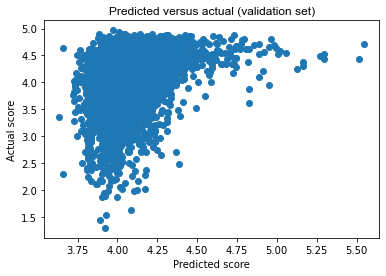

In [134]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

Specifically, way over predicting the lower scoring apps - typically earleir years